# EECS 504 Homework 1
## Problem 1: NFL's Line of Scrimmage

We'll be extending the ideas of Code-Along 2 to a real-world application: using homography fitting to draw a line of scrimmage onto an NFL football field.

### Getting Started
Make your own copy of this notebook using **File -> Save a copy in Drive**, or if you have iPython installed locally, **File -> Download .ipynb** to do the exercises locally.

### Submitting
When you're ready to submit this problem, first run all of the code to ensure your outputs are included in the submission. Save the `.ipynb` file and submit it to Canvas as `HW1.1_<uniqname>.ipynb`, substituting your uniqname. Be sure your name, uniqname, and UMID are correct in the form fields below. If you want to preview how it will look when we grade it, we'll run a command similar to the one below:

`ipython nbconvert --to html HW1.1_<uniqname>.ipynb`



In [ ]:
#@title Grading information
Name = 'Yuan Cheng' #@param {type: 'string'}
Uniqname = 'yuacheng' #@param {type: 'string'}
UMID = '06358288' #@param {type: 'string'}

# Setup

Run the following cells to import and download the modules and data you'll need.

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import IPython

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1dDdk7IrM5oO2gA57_bapqdIgk7CmJV03"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=1V_lui-asfT3Xly4O_Kuez8IDYEZkct4i"
! wget -O point_tracker.html "https://drive.google.com/uc?export=download&id=1I9Xw8u0EdAEsP4GGuNwh267zL5lwxQw_"


# Visualize Input Images

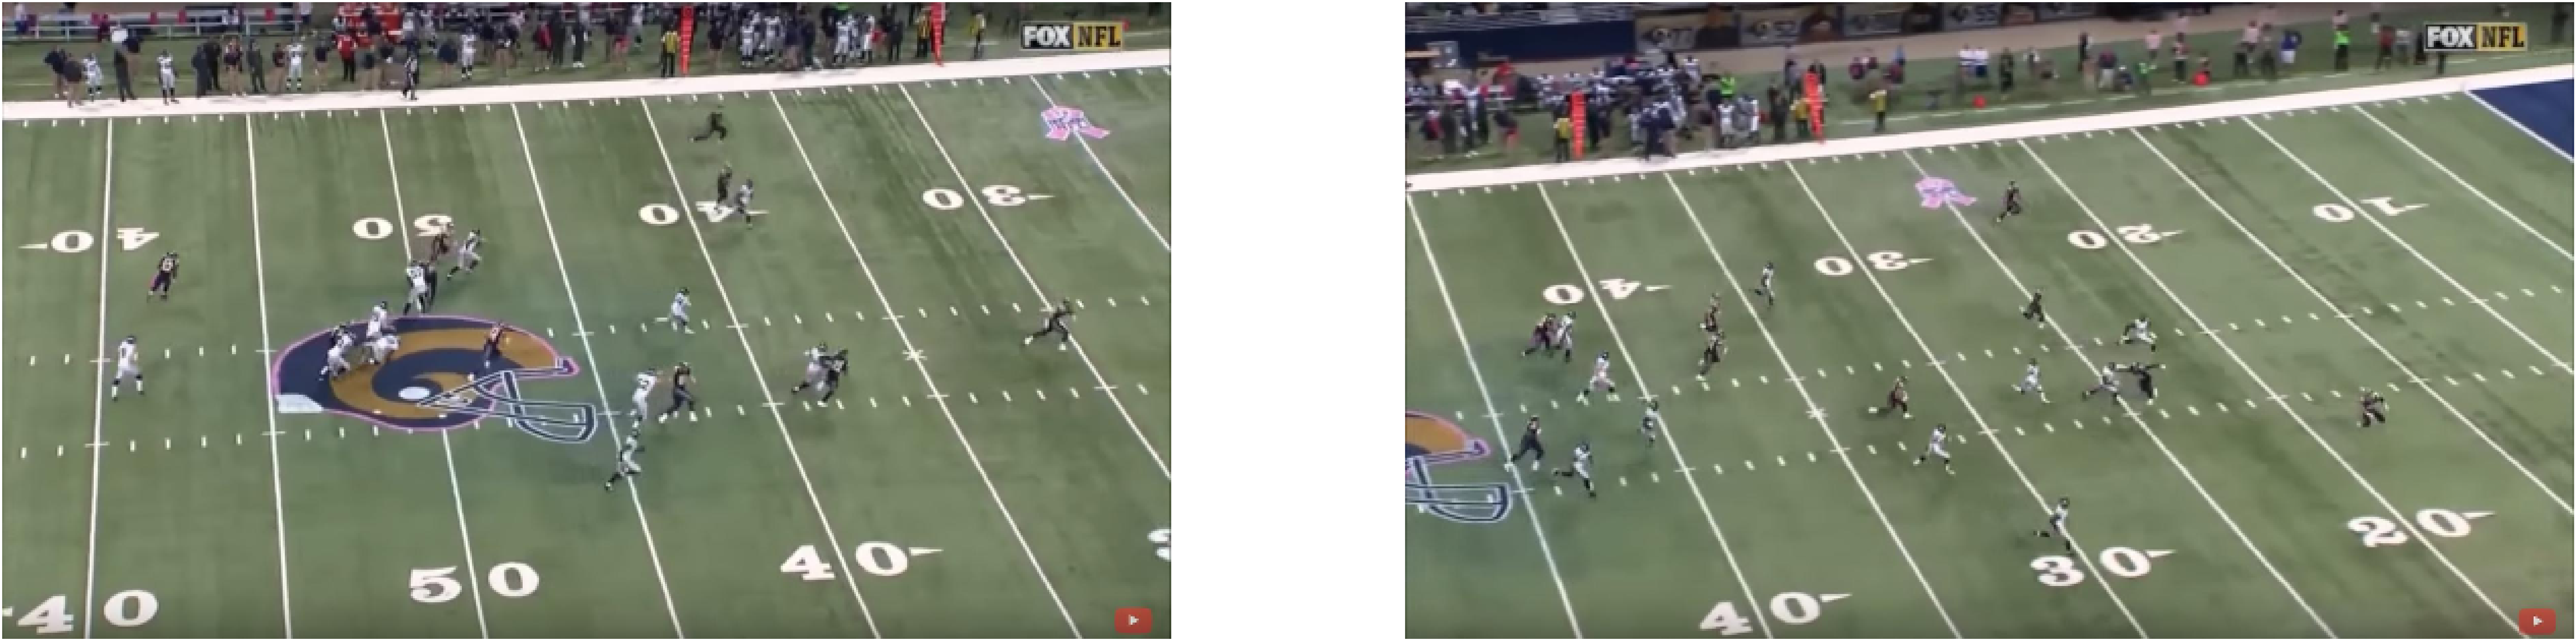

In [ ]:
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1 = cv2.resize(img1,(575, 313))
img2 = cv2.resize(img2,(575, 313))


def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(150, 200))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# Record point correspondences

We will be manually discovering keypoint correspondences for this problem, rather than algorithmically as we did in Code-Along 2. The point tracker tool we've provided shows you the x and y coordinates of your cursor and logs the points you click. Use it to populate the `x1`, `y1`, `x2`, and `y2` lists in the code cell below. Collect as many correspondences as you wish.

In [ ]:
IPython.display.HTML('./point_tracker.html')

In [ ]:
# Use the point tracker to find pairs (x1,y1) and (x2,y2) between the two images that refer to the same field location
x1 = [297, 448, 283, 300, 378, 329, 304, 252, 366, 429, 526, 506, 517, 460, 441, 268, 459, 543]
y1 = [201, 172, 179, 160, 196, 17, 21, 196, 43, 40, 60, 35, 94, 267, 38, 161, 190, 189]
x2 = [56, 201, 41, 57, 137, 78, 51, 10, 116, 175, 265, 245, 258, 219, 187, 25, 212, 286]
y2 = [240, 200, 219, 198, 228, 60, 66, 237, 84, 79, 95, 72, 124, 290, 77, 202, 220, 210]
print(len(x1))

18


## Set up the OLS problem

Construct matrix `A` and vector `B` using the points you recorded above. Feel free to use Code-Along 2 as a guide.

**Note:** In Code-Along 2, we were mapping points from image 2 to image 1. Here, we want to do the reverse: create a homography that maps image 1 to image 2. Change the definition as needed.




In [ ]:
# ===============================================
# TODO


# A = np.array([[]]) 
# B = np.array([[]]) 

  # Initialize A and B
k = 18
A = np.zeros((2*k, 8), dtype=np.float32)
B = np.zeros((2*k, 1), dtype=np.float32)
for r in range(0,2*k,2):
  A[r,0] = x1[int(r/2)]
  A[r,1] = y1[int(r/2)]
  A[r,2] = 1
  A[r,6] = -x2[int(r/2)] * x1[int(r/2)]
  A[r,7] = -x2[int(r/2)] * y1[int(r/2)]
  
for r in range(1,2*k,2):
  A[r,3] = x1[int((r-1)/2)]
  A[r,4] = y1[int((r-1)/2)]
  A[r,5] = 1
  A[r,6] = -y2[int((r-1)/2)] * x1[int((r-1)/2)]
  A[r,7] = -y2[int((r-1)/2)] * y1[int((r-1)/2)]
  
for r in range(2*k):
  if r % 2 == 0:
    B[r] = x2[int(r/2)]
  else:
    B[r] = y2[int((r-1)/2)]
# ===============================================


# Solve for H

Use `A` and `B` to solve for the homography matrix `H` that maps points from image 1 to image 2.

In [ ]:
# ===============================================
# TODO
H,_,_,_ = np.linalg.lstsq(A, B, rcond=None)
H = np.concatenate((H.reshape((-1)), [1.0]), 0).reshape((3,3))
# ===============================================

It is time to check if you got the right homography!

Run the code below. The image on the left has the yellow line at the 33rd yard. If your homography is correct the yellow line in the second image should also be at the 33rd yard. 

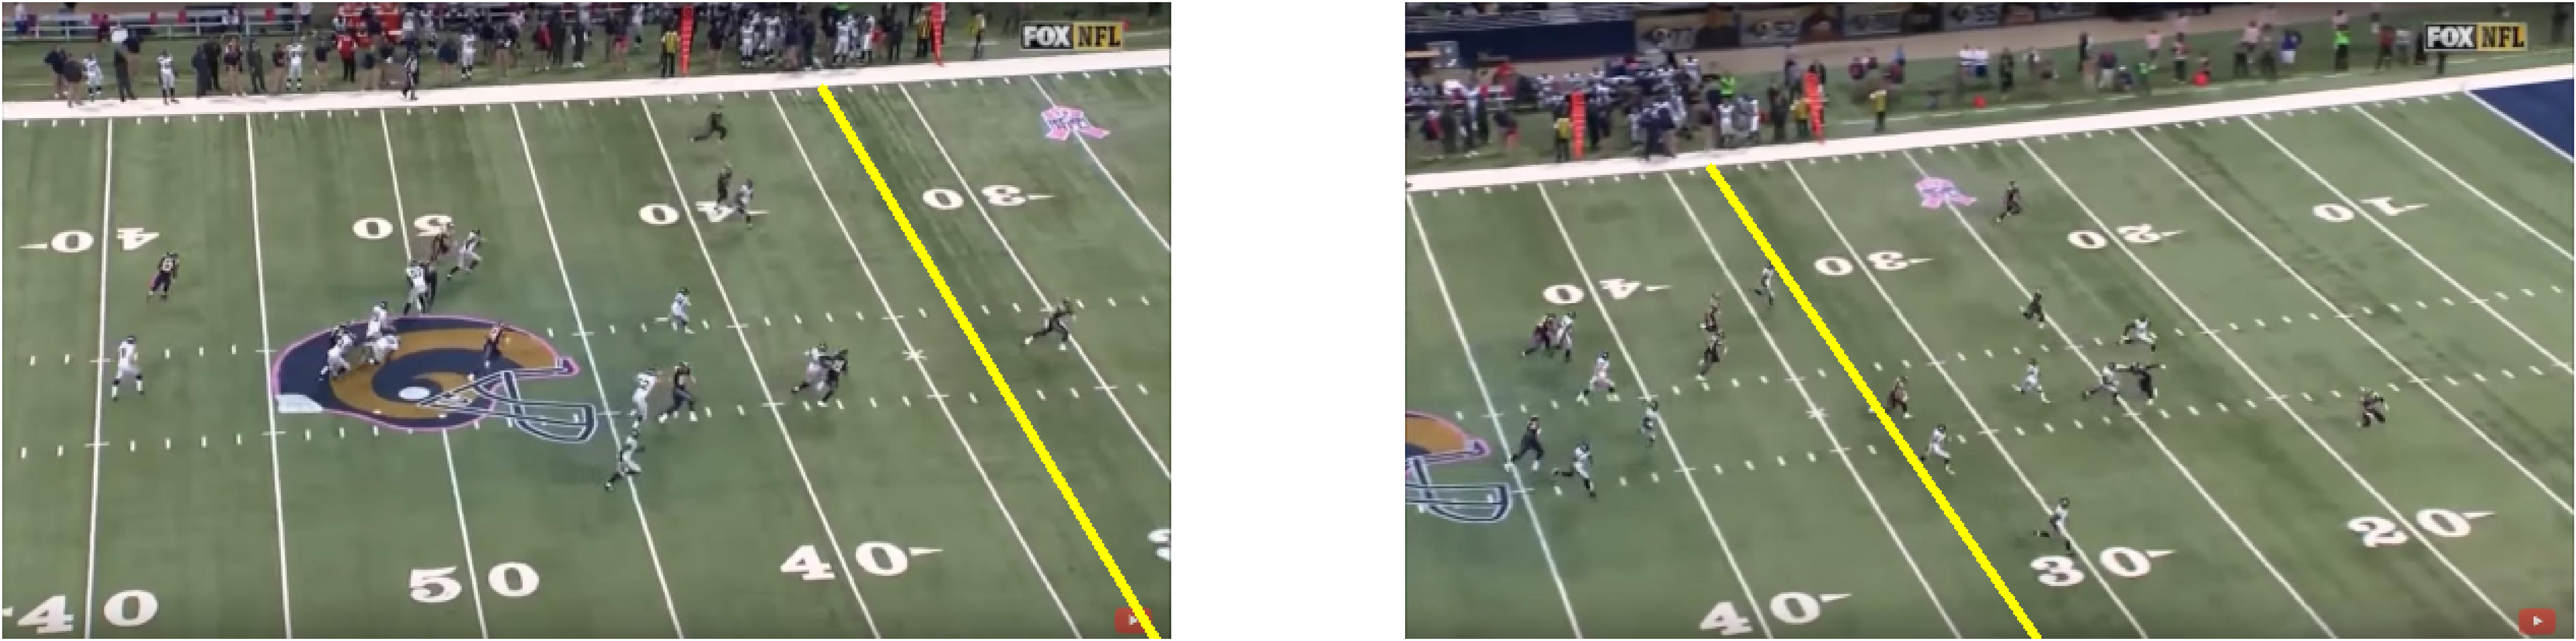

In [ ]:

line_1 = ((int(1210/3), int(126/3)), (int(1701/3), int(939/3)))

#First point of second line
pt1 = H@np.array([[line_1[0][0]],[line_1[0][1]], [1]])
pt1 /= pt1[2,0]

#Second point of second line
pt2 = H@np.array([[line_1[1][0]],[line_1[1][1]], [1]])
pt2 /= pt2[2,0]

line_2 = ((pt1[0], pt1[1]), (pt2[0], pt2[1]))


img1 = cv2.line(img1, (line_1[0][0],line_1[0][1]), (line_1[1][0], line_1[1][1]), (255, 255, 0) , 4)
img2 = cv2.line(img2, (line_2[0][0],line_2[0][1]), (line_2[1][0],line_2[1][1]), (255, 255, 0) , 4)

plot_imgs(img1, img2)

## Going Further

How would you implement a function `lineOfScrimmage(img, yard)` that takes in an image and a yardline number (e.g. 33 for the above example) and returns the image with the line of scrimmage drawn on it? What modifications to the above procedure would you need to make in order to work in yards rather than pixels?

Double click the cell below to fill in your answer.

### Answer:
We can calculate the expression of the yardline at the top the image which is the the boundary of the field: Y = -0.05X + 58.696.

According to the calculation, each line of scrimmage has a different slope but  their slopes are quite similar. So I assume they have the same slope. 

Initially, I need to find the coordinates of points on the yardline, and it is quite simple because I know the equation of the yardline and its intersection with the boundary of the image, I can use the similar triangle method applied on each point and calculate there x and y coordiantes. 

Then I need to find another point'coordinates on the line of scrimmage so that two points can form a line. Since each line of scrimmage has a slightly different slope from each other, I can assume they have the same slope, which means they are parallel to each other.

Since we assume they are parallel to each other, these lines of scrimmage are parallel to the 33 yard line so all the lines of scrimmage have a slope 1.66 so each line of scrimmage can be expressed as (y - y(1)) = 1.66 * (x - x(1)) mathematically and we can find its intersection with the upper bound of the image denoted as x(2), y(2) so line1 = ((x(1), y(1), x(2), y(2))) then we can use cv2.line to draw the line on the image.


